Importing necessary libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from scipy.stats import ttest_rel, wilcoxon

from clean_parent import clean_parent, clean_child
from velocity import fit_spline_with_velocity
from parent_pca import pca_parent_lowrank_approx

Reading in raw datasets and cleaning then

In [3]:
path = "../adv-ml-2025/gen1_train_comp_final.csv"
parent_wide, parent_long = clean_parent(path)

path = "../adv-ml-2025/gen2_train_comp_final.csv"
child_wide, child_long, child2parent, parent2sex, child2sex = clean_child(path)

Making velocity df

In [4]:
child_age_cols = [col for col in child_wide.columns if isinstance(col, (int, float))]
child_features, child_velocity = fit_spline_with_velocity(
    child_wide, age_cols=child_age_cols
)
child_features.rename(
    columns={
        "PHV": "PHV_child",
        "Age_at_PHV": "Age_at_PHV_child",
        "Max_Accel_Age": "Max_Accel_Age_child",
    },
    inplace=True,
)

In [5]:
child_features.loc[:, "sex"] = child_features.index.map(child2sex)
child_features.loc[:, "gen1_id"] = child_features.index.map(child2parent)
child_features.loc[:, "parent_sex"] = child_features.loc[:, "gen1_id"].map(parent2sex)

Compute low rank approximation df and pc score df

In [6]:
low_approx_df, parent_pc_df = pca_parent_lowrank_approx(parent_wide, 99)

In [7]:
merged_df = child_features.merge(
    parent_pc_df, left_on="gen1_id", right_index=True, how="left"
).dropna()

In [8]:
child_wide.loc[:, "sex"] = child_wide.index.map(child2sex)
child_wide.loc[:, "gen1_id"] = child_wide.index.map(child2parent)
child_wide.loc[:, "parent_sex"] = child_wide.loc[:, "gen1_id"].map(parent2sex)

In [9]:
merged_df1 = child_wide.merge(
    parent_pc_df, left_on="gen1_id", right_index=True, how="left"
).dropna()

In [10]:
child_18 = merged_df1[[18, "gen1_id", "parent_sex"]]
child_18 = child_18.rename(columns={18: "target"})

In [11]:
p_2_merge = parent_wide.reset_index()
merge_heights = child_18.merge(p_2_merge, on="gen1_id", how="left")
merge_heights.head()

,target,gen1_id,parent_sex,0.1,0.25,0.5,0.75,1.0,1.5,2.0,...,15.5,16.0,16.5,17.0,17.5,18.0,18.5,19.0,19.5,20.0
0,170.208080,694,M,55.826458,63.402308,70.383307,75.569490,79.949208,84.553615,91.057895,...,184.158103,185.352121,186.178159,186.566052,187.010304,187.320811,187.306432,187.292054,187.700016,188.107978
1,183.780534,383,M,57.149109,65.915863,71.659046,76.222451,80.904377,87.130921,93.343121,...,192.473030,194.305717,194.453334,194.755102,194.676736,194.970999,195.092417,195.213834,195.464294,195.714755
2,167.298785,539,M,53.935810,60.679808,70.313096,74.960685,78.865651,86.224520,93.956054,...,172.912806,175.870532,179.276514,180.730152,182.141760,182.991174,183.055302,184.778050,184.384969,185.051548
3,181.159295,469,M,56.888647,61.649094,70.256912,73.222321,77.203557,84.395504,91.531372,...,173.165838,174.747713,179.356033,182.232486,186.965840,188.761179,189.732545,191.797827,192.428120,193.183434
4,173.033062,576,M,58.514945,64.128871,72.921352,79.790493,84.132856,88.475218,93.098059,...,180.230267,184.040152,186.571063,187.859403,189.477404,189.772037,189.939614,190.502810,191.041194,191.686232


Correlation of parent heights at different ages with final child height

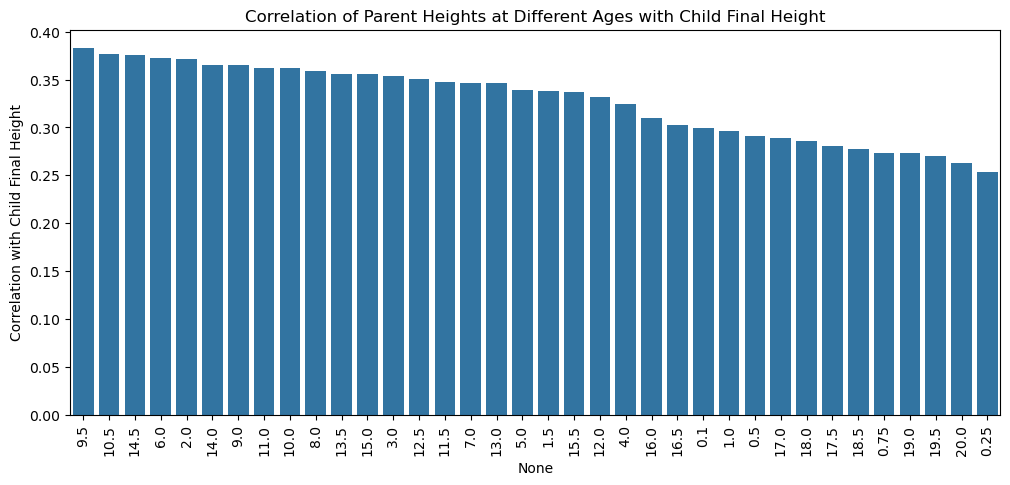

In [12]:
# Select all parent heights
parent_height_cols = merge_heights.iloc[:, 3:].columns.to_list()

# Compute correlation with child's final height
correlations = merge_heights[["target"] + parent_height_cols].corr()

# Extract only the correlations between parent heights and child final height
corr_target = correlations["target"].drop("target").sort_values(ascending=False)

# Ensure sorting is explicitly applied in seaborn
plt.figure(figsize=(12, 5))
sns.barplot(x=corr_target.index, y=corr_target.values, order=corr_target.index)
plt.xticks(rotation=90)
plt.ylabel("Correlation with Child Final Height")
plt.title("Correlation of Parent Heights at Different Ages with Child Final Height")
plt.show()

Only choose those with correlation above 0.3 units

In [13]:
threshold = 0.3  # Set your desired threshold

# Filter correlations above the threshold
high_corr_target = corr_target[
    corr_target.abs() > threshold
]  # Use abs() if you care about both positive & negative correlations


In [14]:
merge_heights["parent_sex"] = merge_heights["parent_sex"].map({"F": 0, "M": 1})

In [15]:
merge_pca = merge_heights.merge(parent_pc_df, left_on="gen1_id", right_index=True)

In [16]:
merge_heights.head()

,target,gen1_id,parent_sex,0.1,0.25,0.5,0.75,1.0,1.5,2.0,...,15.5,16.0,16.5,17.0,17.5,18.0,18.5,19.0,19.5,20.0
0,170.208080,694,1,55.826458,63.402308,70.383307,75.569490,79.949208,84.553615,91.057895,...,184.158103,185.352121,186.178159,186.566052,187.010304,187.320811,187.306432,187.292054,187.700016,188.107978
1,183.780534,383,1,57.149109,65.915863,71.659046,76.222451,80.904377,87.130921,93.343121,...,192.473030,194.305717,194.453334,194.755102,194.676736,194.970999,195.092417,195.213834,195.464294,195.714755
2,167.298785,539,1,53.935810,60.679808,70.313096,74.960685,78.865651,86.224520,93.956054,...,172.912806,175.870532,179.276514,180.730152,182.141760,182.991174,183.055302,184.778050,184.384969,185.051548
3,181.159295,469,1,56.888647,61.649094,70.256912,73.222321,77.203557,84.395504,91.531372,...,173.165838,174.747713,179.356033,182.232486,186.965840,188.761179,189.732545,191.797827,192.428120,193.183434
4,173.033062,576,1,58.514945,64.128871,72.921352,79.790493,84.132856,88.475218,93.098059,...,180.230267,184.040152,186.571063,187.859403,189.477404,189.772037,189.939614,190.502810,191.041194,191.686232


Using key ages and parent sex

Linear Regression R² Score: 0.327
Mean Absolute Error (MAE): 6.72 cm
Root Mean Squared Error (RMSE): 7.38 cm


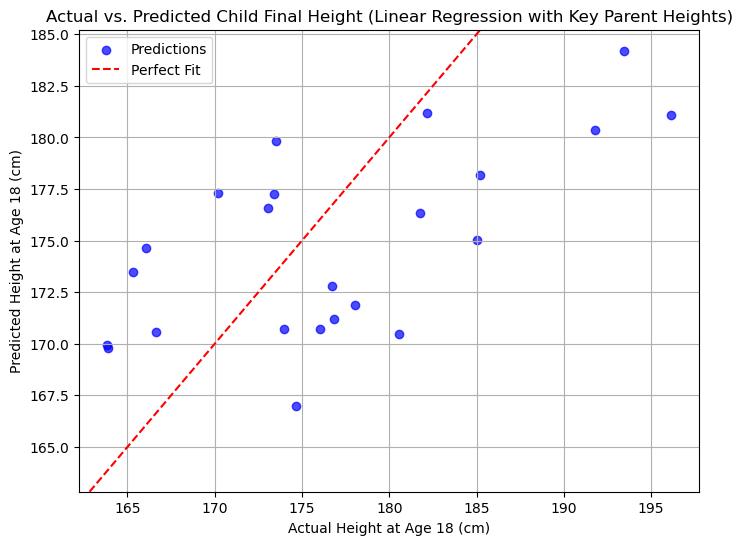

In [17]:
key_ages = [
    0.1,
    2.0,
    6.0,
    9.5,
    10.0,
    10.5,
    11.0,
    11.5,
    12.0,
    13.0,
    14.5,
    15.0,
    "parent_sex",
]

X = merge_heights[key_ages]  # Parent heights at key ages
X.columns = X.columns.astype(str)
y = merge_heights["target"]  # Child's final height

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression Model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = lin_model.predict(X_test)
r2_lin = r2_score(y_test, y_pred)
mae_lin = mean_absolute_error(y_test, y_pred)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression R² Score: {r2_lin:.3f}")
print(f"Mean Absolute Error (MAE): {mae_lin:.2f} cm")
print(f"Root Mean Squared Error (RMSE): {rmse_lin:.2f} cm")

# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predictions")
plt.axline(
    (min(y_test), min(y_test)),
    slope=1,
    linestyle="--",
    color="red",
    label="Perfect Fit",
)
plt.xlabel("Actual Height at Age 18 (cm)")
plt.ylabel("Predicted Height at Age 18 (cm)")
plt.title(
    "Actual vs. Predicted Child Final Height (Linear Regression with Key Parent Heights)"
)
plt.legend()
plt.grid()
plt.show()

Using PC scores

Linear Regression R² Score: 0.144
Mean Absolute Error (MAE): 7.20 cm
Root Mean Squared Error (RMSE): 8.32 cm


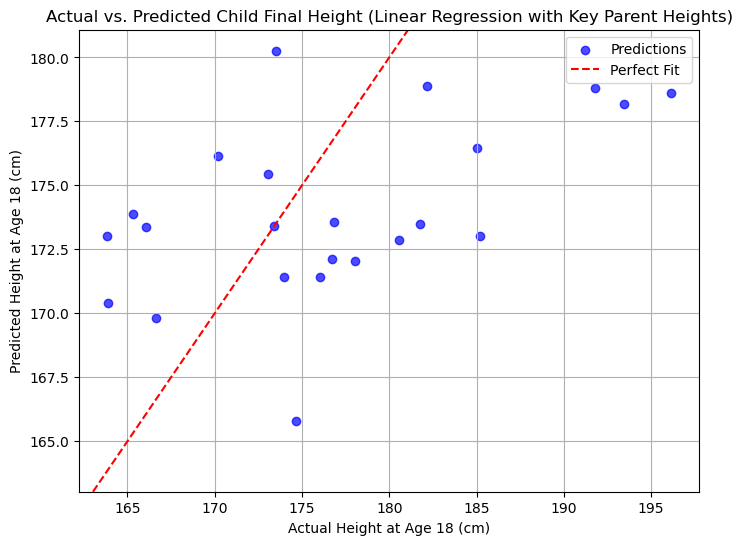

In [18]:
key_ages = [f"PC{i + 1}" for i in range(6)]

X = merge_pca[key_ages]  # Parent heights at key ages
X.columns = X.columns.astype(str)
y = merge_pca["target"]  # Child's final height

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression Model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = lin_model.predict(X_test)
r2_lin = r2_score(y_test, y_pred)
mae_lin = mean_absolute_error(y_test, y_pred)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression R² Score: {r2_lin:.3f}")
print(f"Mean Absolute Error (MAE): {mae_lin:.2f} cm")
print(f"Root Mean Squared Error (RMSE): {rmse_lin:.2f} cm")

# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predictions")
plt.axline(
    (min(y_test), min(y_test)),
    slope=1,
    linestyle="--",
    color="red",
    label="Perfect Fit",
)
plt.xlabel("Actual Height at Age 18 (cm)")
plt.ylabel("Predicted Height at Age 18 (cm)")
plt.title(
    "Actual vs. Predicted Child Final Height (Linear Regression with Key Parent Heights)"
)
plt.legend()
plt.grid()
plt.show()

In [19]:
parent_age_cols = [
    col for col in parent_wide.columns if isinstance(col, (int, float))
]  # Keep only numeric age columns
child_age_cols = [
    col for col in child_wide.columns if isinstance(col, (int, float))
]  # Keep only numeric age columns

# Apply to parents
parent_features, parent_velocity = fit_spline_with_velocity(
    parent_wide, age_cols=parent_age_cols
)
parent_features.rename(
    columns={
        "PHV": "PHV_parent",
        "Age_at_PHV": "Age_at_PHV_parent",
        "Max_Accel_Age": "Max_Accel_Age_parent",
    },
    inplace=True,
)

# Apply to children
child_features, child_velocity = fit_spline_with_velocity(
    child_wide, age_cols=child_age_cols
)
child_features.rename(
    columns={
        "PHV": "PHV_child",
        "Age_at_PHV": "Age_at_PHV_child",
        "Max_Accel_Age": "Max_Accel_Age_child",
    },
    inplace=True,
)

# Display results
print(parent_features.head())
print(child_features.head())

     PHV_parent  Age_at_PHV_parent  Max_Accel_Age_parent
id                                                      
370    7.955339          11.272727              9.000000
371    9.602289           9.000000              9.000000
375    6.799868          14.545455             13.454545
376    6.560289           9.000000             13.454545
377    9.100077           9.000000             13.454545
      PHV_child  Age_at_PHV_child  Max_Accel_Age_child
id                                                    
2509   7.398699          9.545455                  9.0
2510   6.720398         12.636364                  9.0
2512   7.196785         12.181818                  9.0
2513   6.479882         12.090909                  9.0
2514   5.838764         13.272727                  9.0


In [20]:
merge_phv = merge_pca.merge(parent_features, left_on="gen1_id", right_index=True)

Using key ages + PHV 

Linear Regression R² Score: 0.462
Mean Absolute Error (MAE): 5.61 cm
Root Mean Squared Error (RMSE): 6.60 cm


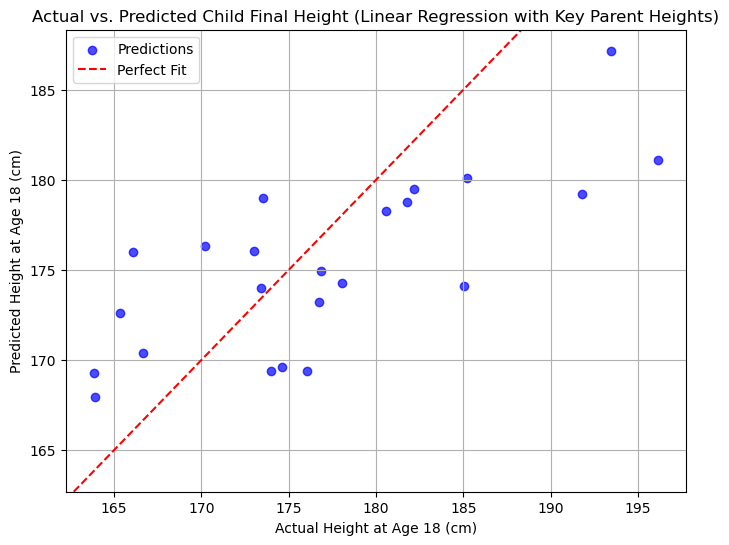

In [21]:
key_ages = [
    0.1,
    2.0,
    6.0,
    9.5,
    10.0,
    10.5,
    11.0,
    11.5,
    12.0,
    13.0,
    14.5,
    15.0,
    "parent_sex",
    "PHV_parent",
]

X = merge_phv[key_ages]  # Parent heights at key ages
X.columns = X.columns.astype(str)
y = merge_phv["target"]  # Child's final height

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression Model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = lin_model.predict(X_test)
r2_lin = r2_score(y_test, y_pred)
mae_lin = mean_absolute_error(y_test, y_pred)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression R² Score: {r2_lin:.3f}")
print(f"Mean Absolute Error (MAE): {mae_lin:.2f} cm")
print(f"Root Mean Squared Error (RMSE): {rmse_lin:.2f} cm")

# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predictions")
plt.axline(
    (min(y_test), min(y_test)),
    slope=1,
    linestyle="--",
    color="red",
    label="Perfect Fit",
)
plt.xlabel("Actual Height at Age 18 (cm)")
plt.ylabel("Predicted Height at Age 18 (cm)")
plt.title(
    "Actual vs. Predicted Child Final Height (Linear Regression with Key Parent Heights)"
)
plt.legend()
plt.grid()
plt.show()

Making baseline, using mean to predict target

In [22]:
# Calculate the mean final height from the training set
mean_final_height = y_train.mean()

# Predict this mean value for all test samples
y_pred_baseline = np.full_like(y_test, mean_final_height)

# Compute performance metrics
r2_baseline = r2_score(y_test, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

print(f"Baseline Model (Mean Predictor) R² Score: {r2_baseline:.3f}")
print(f"Baseline Model MAE: {mae_baseline:.2f} cm")
print(f"Baseline Model RMSE: {rmse_baseline:.2f} cm")

# Compare with our Linear Regression model
print("\nComparison:")
print(f"Our Model R² Score: {r2_lin:.3f} vs. Baseline R² Score: {r2_baseline:.3f}")
print(f"Our Model MAE: {mae_lin:.2f} cm vs. Baseline MAE: {mae_baseline:.2f} cm")
print(f"Our Model RMSE: {rmse_lin:.2f} cm vs. Baseline RMSE: {rmse_baseline:.2f} cm")

Baseline Model (Mean Predictor) R² Score: -0.140
Baseline Model MAE: 7.34 cm
Baseline Model RMSE: 9.60 cm

Comparison:
Our Model R² Score: 0.462 vs. Baseline R² Score: -0.140
Our Model MAE: 5.61 cm vs. Baseline MAE: 7.34 cm
Our Model RMSE: 6.60 cm vs. Baseline RMSE: 9.60 cm


Perform t-test to see if our predictions are better than just using mean to predict target

In [23]:
# Compute absolute errors
baseline_errors = np.abs(y_test - y_test.mean())  # Baseline uses mean predictor
model_errors = np.abs(y_test - y_pred)  # Our model's errors

# Paired t-test
t_stat, p_val_ttest = ttest_rel(baseline_errors, model_errors)

# Wilcoxon signed-rank test (non-parametric)
w_stat, p_val_wilcoxon = wilcoxon(baseline_errors, model_errors)

# Display results
test_results = {
    "Paired t-test": {"t-statistic": t_stat, "p-value": p_val_ttest},
    "Wilcoxon Signed-Rank Test": {"W-statistic": w_stat, "p-value": p_val_wilcoxon},
}

test_results

{'Paired t-test': {'t-statistic': 1.7708869787982828,
  'p-value': 0.09043528840806321},
 'Wilcoxon Signed-Rank Test': {'W-statistic': 89.0,
  'p-value': 0.14241743087768555}}